In [18]:
# work derived from excellent blog post here:
# http://www.turingfinance.com/regression-analysis-using-python-statsmodels-and-quandl/

import os as os
import csv as csv
import numpy as np
import scipy as spy
import sklearn as kit
import pandas as pandas
import statsmodels.api as sm
import matplotlib.pyplot as plot
from quandl import get
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

class StatsModelsSettings():
    """
    This class contains settings for the statsmodels package, settings include,
    * exponent:int - when equal to one this is a straight line, when >1 this is a curve
    * confidence:boolean - specifies whether confidence lines should be calculated and plotted
    """
    exponent = 1
    confidence = False

    def __init__(self, exponent=1, confidence=False):
        """
        This initialization method constructs a new StatsModelSettings object
        """
        self.exponent = exponent
        self.confidence = confidence
        pass


class QuandlSettings():
    """
    This class contains settings for the quandl integration package, settings include,
    * rows:int - specifies the amount of historical data to extract in [frequency]
    * column:int - specifies the column in the data-set to use for the regression analysis
    * frequency:String - select between ("daily"|weekly"|"monthly"|"quarterly"|"annual")
    * transformation:String - select the numerical transformation ("diff"|"rdiff"|"normalize"|"cumul")
    * order:String - select order of data between ("asc"|"desc")
    """
    rows = 0
    column = 1
    frequency = "weekly"
    transformation = "normalize"
    order = "desc"

    def __init__(self, rows, column, frequency="weekly", transformation="normalize", order="desc"):
        """
        This initialization method constructs a new QuandlSettings object
        """
        self.rows = rows
        self.column = column
        self.frequency = frequency
        self.transformation = transformation
        self.order = order
        pass


class RegressionAnalysis():
    """
    This class contain the logic for calculating the regression analysis given a Quandl data-set name, a QuandlSettings
    object, and a StatsModelsSettings object. The resulting regression analysis is returned.
    """
    color = 'r'
    dates = []
    prices = []
    data_set = ""
    regression = None
    upper = None
    lower = None

    def __init__(self, quandl_data_set_name, quandl_settings, statsmodels_settings, color='r'):
        """
        This initialization method constructs a new RegressionAnalysis object
        """
        self.color = color
        self.data_set = quandl_data_set_name
        self.dates, self.prices = self.get_quandl_data(self.data_set, quandl_settings)

        # Only calculate and return confidence lines if setting = True
        if statsmodels_settings.confidence:
            self.regression, self.lower, self.upper = self.run_ordinary_least_squares(self.dates, self.prices,
                                                                                      statsmodels_settings)
        else:
            self.regression = self.run_ordinary_least_squares(self.dates, self.prices, statsmodels_settings)
        pass

    @staticmethod
    def get_quandl_data(quandl_data_set_name, quandl_settings):
        """
        This method retrieves the quandl data set given the settings specified in the quandl_settings object. For more
        information about these settings see documentation from the QuandlSettings class
        """
        quandl_data_set = get(quandl_data_set_name, rows=quandl_settings.rows, returns="numpy",
                              transformation=quandl_settings.transformation,
                              sort_order=quandl_settings.order, collapse=quandl_settings.frequency)
        #print(quandl_data_set)
        quandl_dates = np.arange(1, quandl_settings.rows + 1, 1)
        quandl_prices = []

        # TODO: find a better way to extract some column, X, from numpy matrix of tuples (w, x, y, z)
        for i in range(quandl_data_set.size):
            quandl_prices.append(quandl_data_set[quandl_settings.rows - (i + 1)][quandl_settings.column] / 100)
        return quandl_dates, quandl_prices

    @staticmethod
    def run_ordinary_least_squares(ols_dates, ols_data, statsmodels_settings):
        """
        This method receives the dates and prices of a Quandl data-set as well as settings for the StatsModels package,
        it then calculates the regression lines and / or the confidence lines are returns the objects
        """
        intercept = np.column_stack((ols_dates, ols_dates ** statsmodels_settings.exponent))
        constant = sm.add_constant(intercept)
        statsmodel_regression = sm.OLS(ols_data, constant).fit()
        print(statsmodel_regression.summary())
        if statsmodels_settings.confidence:
            prstd, lower, upper = wls_prediction_std(statsmodel_regression)
            return statsmodel_regression, lower, upper
        else:
            return statsmodel_regression


def plot_regression_line(regression_analyses):
    """
    This global method is a front-end to the MatplotLib library which receives a set of regression analyses and plots
    each one of them onto the canvas.
    """
    title = ""
    fig, ax = plot.subplots(figsize=(10, 10))
    # Plot each regression analysis in the set
    for regression_i in regression_analyses:
        ax.plot(regression_i.dates, regression_i.prices, regression_i.color, label="Values " + regression_i.data_set)
        ax.plot(regression_i.dates, regression_i.regression.fittedvalues, regression_i.color + '.',
                label="Regression line " + regression_i.data_set)
        if regression_i.lower is not None:
            ax.plot(regression_i.dates, regression_i.lower, regression_i.color + '--')
        if regression_i.upper is not None:
            ax.plot(regression_i.dates, regression_i.upper, regression_i.color + '--')
        plot.xlabel('Time')
        plot.ylabel('Normalized Values')
        title += regression_i.data_set + ", "

    plot.title('Regression Analysis of ' + title)
    ax.legend(loc='best')
    plot.grid(True)
    plot.show()


def investing_example():
    """
    This method creates a set of regression analyses based on fundamental trading (revenues)
    """
    # b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
    statsmodels_args_inv = StatsModelsSettings(2, False)
    quandl_args_inv = QuandlSettings(5, 1, "yearly")

    regressions_inv = [RegressionAnalysis("GOOG/NASDAQ_GOOG", quandl_args_inv, statsmodels_args_inv, 'b'),
                       RegressionAnalysis("GOOG/NASDAQ_AAPL", quandl_args_inv, statsmodels_args_inv, 'k')]
    plot_regression_line(regressions_inv)


def trading_example():
    """
    This method creates a set of regression analyses based on technical trading details (price)
    """
    # b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
    statsmodels_args_trade = StatsModelsSettings(1, True)
    quandl_args_trade = QuandlSettings(350, 4, "weekly")

    regressions_trade = [RegressionAnalysis("GOOG/NASDAQ_GOOG", quandl_args_trade, statsmodels_args_trade, 'b'),
                         RegressionAnalysis("GOOG/NASDAQ_YHOO", quandl_args_trade, statsmodels_args_trade, 'g')]
    plot_regression_line(regressions_trade)


def economics_example():
    """
    This method creates a set of regression analyses based on economics GDP's of the BRICS nations,
    """
    # b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
    statsmodels_args = StatsModelsSettings(1, False)
    quandl_args_prices = QuandlSettings(15, 1, "yearly")

    # South Africa, China, Brazil, India, Russia
    regressions = [RegressionAnalysis("WORLDBANK/ZAF_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'b'),
                   RegressionAnalysis("WORLDBANK/CHN_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'g'),
                   RegressionAnalysis("WORLDBANK/BRA_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'k'),
                   RegressionAnalysis("WORLDBANK/IND_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'm'),
                   RegressionAnalysis("WORLDBANK/RUS_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'c')]
    plot_regression_line(regressions)

/usr/local/lib/python2.7/dist-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     39.94
Date:                Fri, 09 Jun 2017   Prob (F-statistic):             0.0244
Time:                        18:46:08   Log-Likelihood:                 9.5235
No. Observations:                   5   AIC:                            -13.05
Df Residuals:                       2   BIC:                            -14.22
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         18.2713      0.122    149.575      0.0

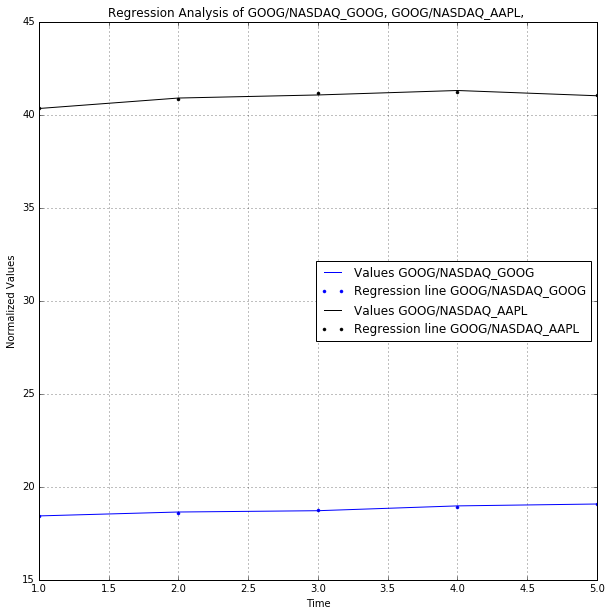

In [19]:
investing_example()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     4747.
Date:                Fri, 09 Jun 2017   Prob (F-statistic):          6.93e-205
Time:                        18:46:43   Log-Likelihood:                -458.00
No. Observations:                 350   AIC:                             920.0
Df Residuals:                     348   BIC:                             927.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.5858      0.096     37.269      0.0

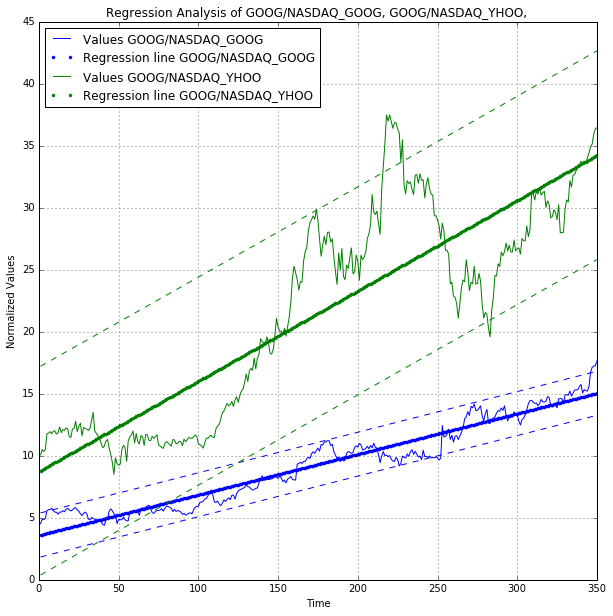

In [20]:
trading_example()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     585.5
Date:                Fri, 09 Jun 2017   Prob (F-statistic):           3.39e-12
Time:                        18:46:55   Log-Likelihood:                 14.680
No. Observations:                  15   AIC:                            -25.36
Df Residuals:                      13   BIC:                            -23.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.3287      0.053     62.717      0.0

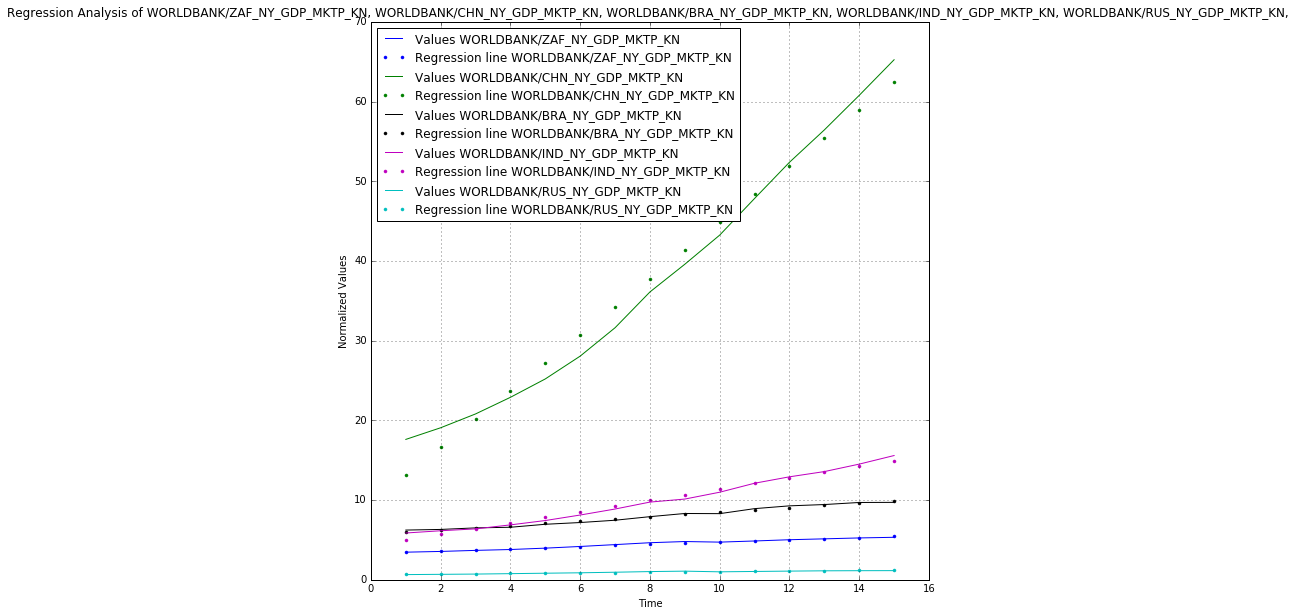

In [21]:
economics_example()